# Exploratory Data Analysis Irish Beef
## Research Question
How has Ireland's beef sector performed compared to the EU 27 countries from 1961 to 2021, and can we forecast future prices using historical data? Additionally, what can we learn from sentiment analysis of the beef industry during this time period?
## Libraries and modules

In [297]:

### Data Manipulation and Analysis
import csv
import pandas as pd
import numpy as np
import fancyimpute
import missingno as msno
from functools import partial, reduce

### Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.image as mpimg

### Statistical Analysis
from scipy.stats import ks_2samp, shapiro

### Machine Learning
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR

### Text Processing
import html
import re

### Country Information
from countryinfo import CountryInfo
import pycountry
from countrygroups import EUROPEAN_UNION

### File System and OS
import glob
import os

### Date and Time
import datetime
import time

### Data Presentation
from tabulate import tabulate
from IPython.display import HTML, Image, display

### Data Types
from typing import Dict, List, Tuple





## Housekeeping   

In [298]:
print(os.getcwd()) # working directory.
print(os.listdir('.')) #List current directory
print(os.listdir('data')) # Our source files from FAOSTAT are in 'data' folder
print(os.listdir('clean')) # Our source files from FAOSTAT are in 'data' folder

C:\Users\ronan\beef
['.git', '.ipynb_checkpoints', '01_eda_beef-Copy1.ipynb', '01_eda_beef.ipynb', '02_ml_beef.ipynb', 'arch', 'beef.pdf', 'belux.csv', 'benelux.csv', 'clean', 'country.csv', 'css', 'data', 'ignore', 'images', 'rain', 'README.md', 'temperature', 'Untitled Folder', 'Untitled.ipynb']
['alive.csv', 'temperature.csv', 'temperature_change.csv', 'temperature_sd.csv']
['benelux.csv', 'benelux_pivot.csv', 'country.csv']


In [299]:
df = pd.read_csv('data/alive.csv')# loads the cattle stock  CSV file to pandas DataFrame n df
print(df.shape) # Inspect the dimensions of the dataset (number of rows and columns). (1708, 14)

(1708, 14)


## Apply data exploration functions to livestock data

In [300]:

df.head()#: returns the first few rows of the DataFrame indicating many fields may be invariant 

Domain Code                        Domain  Area Code (M49)     Area  \
0         QCL  Crops and livestock products               40  Austria   
1         QCL  Crops and livestock products               40  Austria   
2         QCL  Crops and livestock products               40  Austria   
3         QCL  Crops and livestock products               40  Austria   
4         QCL  Crops and livestock products               40  Austria   

   Element Code Element  Item Code (CPC)    Item  Year Code  Year  Unit  \
0          5111  Stocks             2111  Cattle       1961  1961  Head   
1          5111  Stocks             2111  Cattle       1962  1962  Head   
2          5111  Stocks             2111  Cattle       1963  1963  Head   
3          5111  Stocks             2111  Cattle       1964  1964  Head   
4          5111  Stocks             2111  Cattle       1965  1965  Head   

       Value Flag Flag Description  
0  2386761.0    A  Official figure  
1  2456557.0    A  Official figure  
2  2437123.0    A  Official figure  
3  2310667.0    A  Official figure  
4  2350269.0    A  Official figure

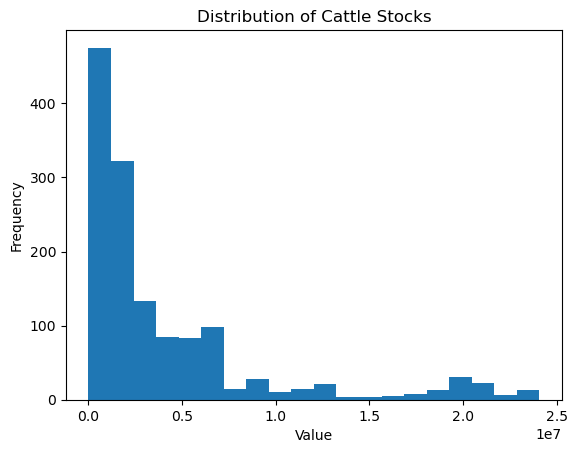

In [301]:
plt.hist(df['Value'], bins=20)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Cattle Stocks')
plt.show() # Bimodal

In [302]:
df.dtypes

Domain Code          object
Domain               object
Area Code (M49)       int64
Area                 object
Element Code          int64
Element              object
Item Code (CPC)       int64
Item                 object
Year Code             int64
Year                  int64
Unit                 object
Value               float64
Flag                 object
Flag Description     object
dtype: object

In [303]:
#Check for missing values 
df.nunique() #  Check for missing values and decide how to handle themWe have 28  country/ regions repoorting and 61 years of data

Domain Code            1
Domain                 1
Area Code (M49)       28
Area                  28
Element Code           1
Element                1
Item Code (CPC)        1
Item                   1
Year Code             61
Year                  61
Unit                   1
Value               1365
Flag                   3
Flag Description       3
dtype: int64

In [306]:
flag_df = df[['Flag', 'Flag Description']].drop_duplicates()
flag_df # There are a lot of estimated and missing categories of reporting- We will hold back on dealing with this for now

Flag   Flag Description
0       A    Official figure
61    NaN                NaN
1160    E    Estimated value
1182    T  Unofficial figure

In [307]:
missing_values = df.isnull().sum()
print(missing_values)#  Check for missing values 

Domain Code           0
Domain                0
Area Code (M49)       0
Area                  0
Element Code          0
Element               0
Item Code (CPC)       0
Item                  0
Year Code             0
Year                  0
Unit                319
Value               319
Flag                319
Flag Description    319
dtype: int64


In [308]:
# Write to CSV file
country.to_csv('clean/country.csv', index=False)
country.head()

Country
0             Austria
1             Belgium
2  Belgium-Luxembourg
3            Bulgaria
4             Croatia

In [309]:
"""
Economic union of Belgium and Luxembourg is called  BELUX   and Economic union of Belgium , 
Luxembourg and the Netherlands is called  BENELUX"""
# Get unique countries
country = df['Area'].unique()

# Convert to a DataFrame
country = pd.DataFrame(countries, columns=['Country'])

In [310]:

benelux  = df[df['Area'].isin(['Belgium-Luxembourg', 'Belgium', 'Luxembourg', 'Netherlands'])]
benelux.sample(5) 

Domain Code                        Domain  Area Code (M49)  \
1259         QCL  Crops and livestock products              528   
169          QCL  Crops and livestock products               58   
128          QCL  Crops and livestock products               58   
103          QCL  Crops and livestock products               56   
74           QCL  Crops and livestock products               56   

                    Area  Element Code Element  Item Code (CPC)    Item  \
1259         Netherlands          5111  Stocks             2111  Cattle   
169   Belgium-Luxembourg          5111  Stocks             2111  Cattle   
128   Belgium-Luxembourg          5111  Stocks             2111  Cattle   
103              Belgium          5111  Stocks             2111  Cattle   
74               Belgium          5111  Stocks             2111  Cattle   

      Year Code  Year  Unit      Value Flag Flag Description  
1259       2000  2000  Head  4070000.0    A  Official figure  
169        2008  2008   NaN        NaN  NaN              NaN  
128        1967  1967  Head  2770000.0    A  Official figure  
103        2003  2003  Head  2778077.0    A  Official figure  
74         1974  1974   NaN        NaN  NaN              NaN

In [311]:


# Reshape the DataFrame with pivot()
benelux_pivot = benelux.pivot(index='Year', columns='Area', values='Value')

# Rename the columns of the pivot table
benelux_pivot.columns = ['{}_stock'.format(col.replace(' ', '_')) for col in benelux_pivot.columns]

# Display the resulting pivot table
benelux_pivot



Belgium_stock  Belgium-Luxembourg_stock  Luxembourg_stock  \
Year                                                              
1961            NaN                 2684120.0               NaN   
1962            NaN                 2798130.0               NaN   
1963            NaN                 2847478.0               NaN   
1964            NaN                 2641407.0               NaN   
1965            NaN                 2685510.0               NaN   
1966            NaN                 2782000.0               NaN   
1967            NaN                 2770000.0               NaN   
1968            NaN                 2784000.0               NaN   
1969            NaN                 2847000.0               NaN   
1970            NaN                 2899000.0               NaN   
1971            NaN                 2901000.0               NaN   
1972            NaN                 2829000.0               NaN   
1973            NaN                 2942000.0               NaN   
1974            NaN                 3104000.0               NaN   
1975            NaN                 3102000.0               NaN   
1976            NaN                 3010711.0               NaN   
1977            NaN                 3022000.0               NaN   
1978            NaN                 3019000.0               NaN   
1979            NaN                 3085000.0               NaN   
1980            NaN                 3111000.0               NaN   
1981            NaN                 3116000.0               NaN   
1982            NaN                 3072000.0               NaN   
1983            NaN                 3115000.0               NaN   
1984            NaN                 3184000.0               NaN   
1985            NaN                 3210000.0               NaN   
1986            NaN                 3163000.0               NaN   
1987            NaN                 3190000.0               NaN   
1988            NaN                 3159000.0               NaN   
1989            NaN                 3174000.0               NaN   
1990            NaN                 3257000.0               NaN   
1991            NaN                 3360000.0               NaN   
1992            NaN                 3311000.0               NaN   
1993            NaN                 3303000.0               NaN   
1994            NaN                 3289000.0               NaN   
1995            NaN                 3369000.0               NaN   
1996            NaN                 3363000.0               NaN   
1997            NaN                 3280000.0               NaN   
1998            NaN                 3184000.0               NaN   
1999            NaN                 3395000.0               NaN   
2000      3041560.0                       NaN          205072.0   
2001      3037760.0                       NaN          205193.0   
2002      2891260.0                       NaN          197257.0   
2003      2778077.0                       NaN          189674.0   
2004      2738648.0                       NaN          186725.0   
2005      2698649.0                       NaN          185235.0   
2006      2669076.0                       NaN          183640.0   
2007      2649392.0                       NaN          191928.0   
2008      2605532.0                       NaN          195661.0   
2009      2600453.0                       NaN          196470.0   
2010      2593000.0                       NaN          198892.0   
2011      2560319.0                       NaN          192535.0   
2012      2484272.0                       NaN          188473.0   
2013      2454704.0                       NaN          193623.0   
2014      2477236.0                       NaN          198780.0   
2015      2503262.0                       NaN          201036.0   
2016      2501349.0                       NaN          201416.0   
2017      2385988.0                       NaN          202281.0   
2018      2398090.0                       NaN        

In [312]:
# Keep only the 'Area', 'Year'  and 'Value' columns
benelux = benelux[['Area','Year', 'Value']]
# Write to CSV file
country_df.to_csv('clean/benelux.csv', index=False)

In [313]:

print(os.listdir('clean'))


['benelux.csv', 'benelux_pivot.csv', 'country.csv']


In [314]:
# Write to CSV file
benelux_pivot.to_csv('clean/benelux_pivot.csv', index=False)
print(os.listdir('clean'))

['benelux.csv', 'benelux_pivot.csv', 'country.csv']


## Beef stock reporting change
We zoom in on the df around 2000 and compare the three countries by plot with the Netherland s now acting as an exemplar of the rest of the coutries

In [315]:
#
benelux_pivot_1995_2005 = benelux_pivot.loc['1997':'2002']
benelux_pivot_1995_2005.head(6)

Belgium_stock  Belgium-Luxembourg_stock  Luxembourg_stock  \
Year                                                              
1997            NaN                 3280000.0               NaN   
1998            NaN                 3184000.0               NaN   
1999            NaN                 3395000.0               NaN   
2000      3041560.0                       NaN          205072.0   
2001      3037760.0                       NaN          205193.0   
2002      2891260.0                       NaN          197257.0   

      Netherlands_stock  
Year                     
1997          4411000.0  
1998          4283000.0  
1999          4206000.0  
2000          4070000.0  
2001          4047000.0  
2002          3858000.0

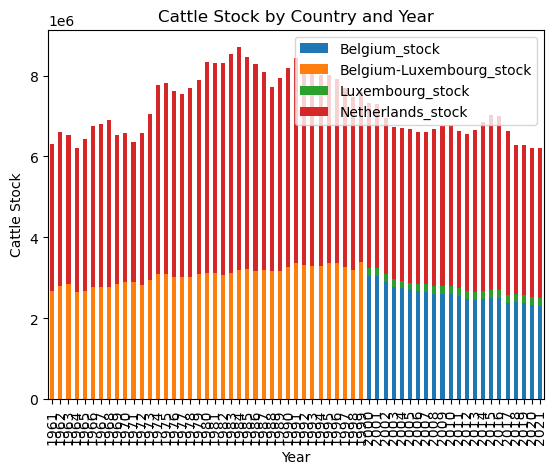

In [316]:
fig, ax = plt.subplots()

benelux_pivot.plot(kind='bar', stacked=True, ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('Cattle Stock')
ax.set_title('Cattle Stock by Country and Year')

plt.show()

## Investigate historical  cattle stock reporting in the  BELUX union and Belgium  Luxembourg
In Pandas, the unique() method was used above  used to return a unique array of values. We discovered that there were 28 unique entries for "Area" despite there being only 27 EU countries. Further investigation revealed that Belgium and Luxembourg reported economic data as one region, and the Netherlands also participated in the Benelux economic union with these two countries. To ensure a comprehensive investigation, we filtered the DataFrame to only include data from these three countries and The pivot() method in pandas was used to reshape the DataFrame and compare reporting and missing cattle stock reports.The  Netherlands reported cattle stock independently for all 61 years of our research interval, while Belgium 
and Luxembourg reported collectively as the Benelux region from 1961 to 1999 when they started reporting individually.
## A revised research question
A revised research question could be: How has Ireland's beef sector performed compared to the EU 27 countries since 2000, and can we forecast future prices using this historical data? Additionally, what can we learn from sentiment analysis of the beef industry during this time period? By focusing on data from 2000 onwards, we can better capture the current state of the beef industry and make more relevant predictions about future trends. At the end of 1999, the Benelux union ceased to report beef stock data as a single entity, as each member country began reporting its data individually. This change reflected the increasing economic development and growth of the individual countries within the union.

## Returning to the master beef stock reporting file


In [317]:
df = df.loc[df['Area'] != 'Belgium-Luxembourg'] #Exclude 'Belgium-Luxembourg' from the 'Area' column in df.

In [318]:
"""Creats a new DataFrame with Year>=2000 and keeps old  familiar name df"""
df = df[df['Year'] >= 2000]

In [319]:
df = df.rename(columns={'Value': 'Stocks', 'Area': 'Country'}) #Renamed 'Value' column to 'Stocks' and Area column to Country.

In [320]:
df.head() # Check that  filtering and renaming worked correctly

Domain Code                        Domain  Area Code (M49)  Country  \
39         QCL  Crops and livestock products               40  Austria   
40         QCL  Crops and livestock products               40  Austria   
41         QCL  Crops and livestock products               40  Austria   
42         QCL  Crops and livestock products               40  Austria   
43         QCL  Crops and livestock products               40  Austria   

    Element Code Element  Item Code (CPC)    Item  Year Code  Year  Unit  \
39          5111  Stocks             2111  Cattle       2000  2000  Head   
40          5111  Stocks             2111  Cattle       2001  2001  Head   
41          5111  Stocks             2111  Cattle       2002  2002  Head   
42          5111  Stocks             2111  Cattle       2003  2003  Head   
43          5111  Stocks             2111  Cattle       2004  2004  Head   

       Stocks Flag Flag Description  
39  2152811.0    A  Official figure  
40  2155447.0    A  Official figure  
41  2118454.0    A  Official figure  
42  2066942.0    A  Official figure  
43  2052033.0    A  Official figure

In [321]:
df = df[["Country", "Year", "Stocks", "Flag", "Flag Description"]]

In [322]:
df.shape# returns the dimensions of the DataFrame as (1708, 14)
df.tail()

Country  Year     Stocks Flag Flag Description
1703  Sweden  2017  1448590.0    A  Official figure
1704  Sweden  2018  1435450.0    A  Official figure
1705  Sweden  2019  1404670.0    A  Official figure
1706  Sweden  2020  1390960.0    A  Official figure
1707  Sweden  2021  1389890.0    A  Official figure

In [323]:
df.isnull().sum()# returns the number of missing values in each column.

Country             0
Year                0
Stocks              0
Flag                0
Flag Description    0
dtype: int64

In [326]:
flag_df = df[['Flag', 'Flag Description']].drop_duplicates()
flag_df # Unofficial and estimated reports were illiminated with other interventions!

Flag Flag Description
39    A  Official figure

In [324]:
# The absence of mising values frees us up to cast values to integers. We can't have live bovine parts!
df['Stocks'] = df['Stocks'].astype(int)
df.dtypes


Country             object
Year                 int64
Stocks               int32
Flag                object
Flag Description    object
dtype: object

In [325]:
df.info()# provides a concise summary of the DataFrame, including column data types, non-null values, and memory usage.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594 entries, 39 to 1707
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Country           594 non-null    object
 1   Year              594 non-null    int64 
 2   Stocks            594 non-null    int32 
 3   Flag              594 non-null    object
 4   Flag Description  594 non-null    object
dtypes: int32(1), int64(1), object(3)
memory usage: 25.5+ KB


## Data is begging to look clean and lean
put we are not there yet

In [ ]:
df.describe()#computes various summary statistics, including count, mean, std, min, and max, for each numeric column.

In [ ]:
df.value_counts()#returns the count of unique values in a column.

In [ ]:
df.groupby('Area')# groups the DataFrame by one or more columns and applies a function to each group.

In [ ]:
df

In [ ]:
df.corr()# computes the correlation between each pair of numeric columns.

In [ ]:

df['Value'] = df['Value'].astype(int) # Recast stock to int

In [ ]:
sns.pairplot()# creates a scatterplot matrix of all the numeric variables in the DataFrame.

In [ ]:
sns.heatmap()# creates a heatmap to visualize the correlation matrix.

In [ ]:
df.isnull().sum()
"""The output shows that there are missing values in the columns 
'Unit', 'Value', 'Flag', and 'Flag Description'. 
or each of these columns, there are 319 missing values."""

In [ ]:
df.info # DF summary with column data types, non-null values, and memory usage, to aid in memory optimization.

In [ ]:
df.describe()

### df.describe() output
df.describe() outputs a statistical summary for 6 columns but the  "Value" output is the only one of concern.

The df.describe() function provides various statistics for the 6 specified columns in the livestock dataframe, such as the mean, standard deviation, minimum, and maximum values.

It can be useful for quickly understanding the distribution of data in the dataframe, and identifying potential outliers or extreme values.

In this case, the lowest stock is 6731 head of cattle and the highest  is 24 million. The Median is 1.9 million and the mean is about 4 milliom which immediatly suggest that the data is skewed and not normally distributed.  We will return to these initial explorations  later in the analysis and interpretation of the data.

 The "Value" column has 319 missing values. That is an important point!

In [ ]:
df.value_counts()

###  unique combination of values from df.value_counts()
The output shows the number of occurrences of each unique combination of values in the columns "Domain Code", "Domain", "Area Code (M49)", "Area", "Element Code", "Element", "Item Code (CPC)", "Item", "Year Code", "Year", "Unit", "Value", "Flag" and "Flag Description" in the DataFrame df.

It seems that the DataFrame contains 1389 unique rows, with each row corresponding to a particular combination of values in the aforementioned columns. For example, there is one row that has a Domain Code of QCL, a Domain of Crops and livestock products, an Area Code (M49) of 40, an Area of Austria, an Element Code of 5111, an Element of Stocks, an Item Code (CPC) of 2111, an Item of Cattle, a Year Code of 1961, a Year of 1961, a Unit of Head, a Value of 2386761.0, a Flag of A, and a Flag Description of Official figure.

It's also worth noting that there are several rows that have the same combination of values in all the columns, indicating that there are duplicate entries in the dataset.

In [ ]:
cardinals = df.nunique()
print(cardinals) #Print unique values count for each column in livestock dataframe
df.sample(4)

## Clean

In [ ]:
df=df.columns = ['Area', 'Element', 'Item', 'Year', 'Unit', 'Value', 'Flag', 'Flag Description']


In [ ]:
"""rename() method names and  removes special characters """
df = df.rename(columns={'Domain Code': 'Dom_Cd', 'Area Code (M49)': 'Area_Cd', 'Element Code': 'ECode', 'Item Code (CPC)': 'Item_Code', 'Year Code': 'Yr Code','Flag Description'
:'Flag_dsc'})


In [ ]:
"""Shorten a constant string entry"""
df['Domain'] = df['Domain'].str.replace('Crops and livestock products', 'LS ')

In [ ]:
""" 'Belgium-Luxembourg'  counted as  separate country to Belgium and Luxembourg"""
df['Area'].unique()

In [ ]:
"""Shortens occurences of Belgium-Luxembourg  which is an anomaly in the datat"""
df["Area"] = df["Area"].replace("Belgium-Luxembourg", "BeLux")


In [ ]:

# # Write the DataFrame and a sampled Dataframe  to 2 CSVs in the processed data folder
# df.to_csv('../clean/livestock.csv', index=False)
# df.sample(40).to_csv('../data/processed/livestock_sample.csv', index=False)

In [ ]:
df.sample(10)

In [ ]:
headers = df.columns.tolist()
headers


In [ ]:
def scanp():
    """Scans the raw data folder and prints contents information.

    Parameters:
        None

    Returns:
        Prints out contents information of the raw data folder.
    """ 
    folder_name = '../data/processed'
    current_dir = os.getcwd()
    folder_path = os.path.join(current_dir, folder_name)
    try:
        contents = os.listdir(folder_path)
    except FileNotFoundError:
        print("Directory not found")
        return
    except OSError:
        print("Invalid folder path")
        return
    print("Contents of the folder '{}':".format(folder_name))
    for item in contents:
        item_path = os.path.join(folder_path, item)
        if os.path.isfile(item_path):
            size = os.path.getsize(item_path)
            modified_time = datetime.datetime.fromtimestamp(os.path.getmtime(item_path)).strftime('%Y-%m-%d %H:%M')
            print("{:30} {:10} {}".format(item, size, modified_time))
        else:
            print("{} (directory)".format(item))
scanp()

In [ ]:
!pip install ipython-latex

In [ ]:
df.head()


In [ ]:
ds=df.head()
ds


In [ ]:






# get column names
headers = df.head(5).columns.tolist()

# set column width
col_width = [1.5, 1, 1.5,1.5, 1, 1.5,1,1,1,1,1,1,1,1,1,1,1]

# create a list of lists from the dataframe
table = df.values.tolist()

# create the LaTeX table using tabulate
latex_table = tabulate(table, headers, tablefmt='latex_booktabs')

# add the column width specifier to the LaTeX table
latex_table = latex_table.replace('\\begin{tabular}', '\\begin{tabular}{%s}' % '|'.join(['p{%.2fcm}' % w  col_width]))

print(latex_table)

…or push an existing repository from the command line
git remote add origin https://github.com/ronandownes/irl_beed_analysis.git
git branch -M main
git push -u origin main

In [ ]:
$$
\begin{tabular}{p{1.50cm}|p{1.00cm}|p{1.50cm}}{lrl}
\toprule
 Name   &   Age & City     \\
\midrule
 John   &    25 & New York \\
 Alice  &    30 & Paris    \\
 Bob    &    35 & London   \\
\bottomrule
\end{tabular}
$$

In [ ]:
df.dtypes

In [ ]:

# convert dataframe to list of lists
table = ds.values.tolist()



# use tabulate to create a table
print(tabulate(table, headers, tablefmt='latex_booktabs'))


In [ ]:

# Pandas DataFrame,'df' in latex table out
table = tabulate(df.sample(40), headers='keys', tablefmt='latex', floatfmt=".2f")
print(table)


In [ ]:

def generate_rotated_table(df: pd.DataFrame, caption: str, label: str) -> str:
    # Start the LaTeX tabular environment
    latex = "\\begin{table}[h]\n"
    latex += "\\centering\n"
    latex += "\\begin{tabular}{|c|c|c|c|c|c|c|c|c|c|c|c|c|}\n"
    latex += "\\hline\n"
    
    # Add the table headers
    headers = list(df.columns)
    for header in headers:
        latex += "\\rotatebox{90}{" + header + "} & "
    latex = latex[:-2] + "\\\\\n"
    latex += "\\hline\n"
    
    # Add the table rows
    for row in df.iterrows():
        latex += " & ".join([str(item) for item in row[1]]) + " \\\\\n"
    
    # End the LaTeX tabular environment and add the caption and label
    latex += "\\hline\n"
    latex += "\\end{tabular}\n"
    latex += "\\caption{" + caption + "}\n"
    latex += "\\label{" + label + "}\n"
    latex += "\\end{table}"
    
    return latex


In [ ]:
# Assume your data is in a pandas DataFrame called 'df'
table = tabulate(livestock, headers='keys', tablefmt='latex', floatfmt=".2f")
print(table)

In [ ]:
generate_rotated_table(df.sample(40),'Sample of Livestock data before EDA','tab:livestock')

In [ ]:


# Convert df to a LaTeX table
table = tabulate(df, headers='keys', tablefmt='latex')
# Print the LaTeX table
print(table)


In [ ]:
### Drop Belgium-Luxembourg
# Drop "Production" column
df = df.drop(df[df['Area'] == 'Belgium-Luxembourg'].index)
# Reset the index
df = df.reset_index(drop=True)
print(df.head())

In [ ]:
# Get the shape of the DataFrame
print(df.shape)

In [ ]:
# Get a list of unique countries from the "Area" column
countries = df['Area'].unique()
countries

In [ ]:
# count the number of missing values in each column
missing_values = df.isnull().sum()

# print the result
print(missing_values)

In [ ]:
# Count the number of areas with missing values
num_missing_areas = df['Area'][df.isna().any(axis=1)].nunique()

# Print the result
print("The number of areas with missing values is:", num_missing_areas)


In [ ]:
31900/1708 # 20% data is missing

In [ ]:
df.shape    

In [ ]:
snake('Distribution of Missing Values by Area')

In [ ]:
snake('msno.matrix(df)')

In [ ]:
msno.matrix(df)

In [ ]:
# create a bar chart of the missing value counts by year
plt.figure(figsize=(20,8))  # increase the figure size for better readability
ax = year_counts.plot(kind='bar')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Missing Values', fontsize=14)
plt.title('Distribution of Missing Values by Year', fontsize=18)
plt.xticks(rotation=0, fontsize=12)  # rotate x-axis labels to 0 degrees
ax.tick_params(axis='y', labelsize=12)  # adjust y-axis label size
ax.tick_params(axis='x', pad=10)  # adjust x-axis tick padding

# add value labels to the bars
for i, v in enumerate(year_counts):
    ax.text(i, v, str(v), ha='center', va='bottom', fontweight='bold', fontsize=12)

# set year labels vertically
ax.set_xticklabels(year_counts.index, rotation=90)

plt.show()


In [ ]:
""" 
A new dataframe with counts of missing values 
for each country was sorted in descending order
revealing  the top 10 countries

"""


# create a new dataframe to hold the counts of missing values by country
country_counts = df.isnull().sum(axis=1).groupby(df.Area).sum().sort_values(ascending=False)

# get the top 10 countries with the most missing values
top_10_countries = country_counts.head(10)

# print the list of top 10 countries
print(top_10_countries)

In [ ]:
# create a new dataframe to hold the counts of missing values by country
country_counts = df.isnull().sum(axis=1).groupby(df.Area).sum().sort_values(ascending=True)

# get the list of countries with any missing values
missing_countries = country_counts[country_counts > 0].index

# print the list of countries with missing values
print("Countries with missing values:\n", missing_countries)


In [ ]:
# create a new dataframe to hold the counts of missing values by country
country_counts = df.isnull().sum(axis=1).groupby(df.Area).sum().sort_values(ascending=True)

# get the list of countries with any missing values
missing_countries = country_counts[country_counts > 0].index

# print the list of countries with missing values
print("Countries with missing values:\n", missing_countries)


In [ ]:
# create a new dataframe to hold the counts of missing values by country
country_counts = df.isnull().sum(axis=1).groupby(df.Area).sum().sort_values(ascending=True)

# get the list of countries with any missing values
missing_countries = country_counts[country_counts > 0]

# create a new dataframe with the missing value counts and the total number of observations for each country
mv_counts = pd.concat([missing_countries, df.groupby('Area').size()], axis=1)
mv_counts.columns = ['Missing Values', 'Total Observations']

# calculate the proportion of missing values for each country
mv_counts['% Missing'] = mv_counts['Missing Values'] / mv_counts['Total Observations'] * 100

# sort the dataframe by the proportion of missing values in descending order
mv_counts = mv_counts.sort_values('% Missing', ascending=False)

# display the table
print(mv_counts.to_string())


In [ ]:

# group the data by Area and compute the total count of missing values for each group
area_counts = df.isnull().sum(axis=1).groupby(df.Area).sum()

# create a bar chart of the missing value counts by Area
plt.figure(figsize=(10,5))
ax = area_counts.plot(kind='bar')
plt.xlabel('Area')
plt.ylabel('Number of Missing Values')
plt.title('Distribution of Missing Values by Area')
plt.xticks(rotation=45)

# add value labels to the bars
for i, v in enumerate(area_counts):
    ax.text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.show()

In [ ]:
df.dtypes

In [ ]:
unique_describtions = df['Flag Description'].unique()
print(unique_describtions)

In [ ]:
df

In [ ]:
df= df[df['Year'] > 1999]

In [ ]:
df.sample(11)

<h1>Table of Contents (Clickable in sidebar)<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Research-Question" data-toc-modified-id="Research-Question-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Research Question</a></span></li><li><span><a href="#Libraries-and-modules" data-toc-modified-id="Libraries-and-modules-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Libraries and modules</a></span></li><li><span><a href="#Housekeeping" data-toc-modified-id="Housekeeping-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Housekeeping</a></span></li><li><span><a href="#Apply-data-exploration-functions-to-livestock-data" data-toc-modified-id="Apply-data-exploration-functions-to-livestock-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Apply data exploration functions to livestock data</a></span></li><li><span><a href="#Beef-stock-reporting-change" data-toc-modified-id="Beef-stock-reporting-change-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Beef stock reporting change</a></span></li><li><span><a href="#Investigate-historical--cattle-stock-reporting-in-the--BELUX-union-and-Belgium--Luxembourg" data-toc-modified-id="Investigate-historical--cattle-stock-reporting-in-the--BELUX-union-and-Belgium--Luxembourg-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Investigate historical  cattle stock reporting in the  BELUX union and Belgium  Luxembourg</a></span></li><li><span><a href="#A-revised-research-question" data-toc-modified-id="A-revised-research-question-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>A revised research question</a></span></li><li><span><a href="#Returning-to-the-master-beef-stock-reporting-file" data-toc-modified-id="Returning-to-the-master-beef-stock-reporting-file-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Returning to the master beef stock reporting file</a></span><ul class="toc-item"><li><span><a href="#df.describe()-output" data-toc-modified-id="df.describe()-output-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>df.describe() output</a></span></li><li><span><a href="#unique-combination-of-values-from-df.value_counts()" data-toc-modified-id="unique-combination-of-values-from-df.value_counts()-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>unique combination of values from df.value_counts()</a></span></li></ul></li><li><span><a href="#Clean" data-toc-modified-id="Clean-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Clean</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Data-Input/Output:" data-toc-modified-id="Data-Input/Output:-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Data Input/Output:</a></span></li><li><span><a href="#Data-Cleaning:" data-toc-modified-id="Data-Cleaning:-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>Data Cleaning:</a></span></li><li><span><a href="#Data-Exploration:" data-toc-modified-id="Data-Exploration:-10.3"><span class="toc-item-num">10.3&nbsp;&nbsp;</span>Data Exploration:</a></span></li><li><span><a href="#Data-Transformation" data-toc-modified-id="Data-Transformation-10.4"><span class="toc-item-num">10.4&nbsp;&nbsp;</span>Data Transformation</a></span><ul class="toc-item"><li><span><a href="#Split" data-toc-modified-id="Split-10.4.1"><span class="toc-item-num">10.4.1&nbsp;&nbsp;</span>Split</a></span></li></ul></li><li><span><a href="#Data-Combination:" data-toc-modified-id="Data-Combination:-10.5"><span class="toc-item-num">10.5&nbsp;&nbsp;</span>Data Combination:</a></span><ul class="toc-item"><li><span><a href="#Pascal" data-toc-modified-id="Pascal-10.5.1"><span class="toc-item-num">10.5.1&nbsp;&nbsp;</span>Pascal</a></span></li><li><span><a href="#Total-Character" data-toc-modified-id="Total-Character-10.5.2"><span class="toc-item-num">10.5.2&nbsp;&nbsp;</span>Total Character</a></span></li></ul></li><li><span><a href="#Scanners,--Readers-and-Writers" data-toc-modified-id="Scanners,--Readers-and-Writers-10.6"><span class="toc-item-num">10.6&nbsp;&nbsp;</span>Scanners,  Readers and Writers</a></span><ul class="toc-item"><li><span><a href="#Scanners" data-toc-modified-id="Scanners-10.6.1"><span class="toc-item-num">10.6.1&nbsp;&nbsp;</span>Scanners</a></span></li><li><span><a href="#Readers" data-toc-modified-id="Readers-10.6.2"><span class="toc-item-num">10.6.2&nbsp;&nbsp;</span>Readers</a></span></li><li><span><a href="#Splitters" data-toc-modified-id="Splitters-10.6.3"><span class="toc-item-num">10.6.3&nbsp;&nbsp;</span>Splitters</a></span></li><li><span><a href="#Delete" data-toc-modified-id="Delete-10.6.4"><span class="toc-item-num">10.6.4&nbsp;&nbsp;</span>Delete</a></span></li><li><span><a href="#Rename" data-toc-modified-id="Rename-10.6.5"><span class="toc-item-num">10.6.5&nbsp;&nbsp;</span>Rename</a></span></li><li><span><a href="#Replace" data-toc-modified-id="Replace-10.6.6"><span class="toc-item-num">10.6.6&nbsp;&nbsp;</span>Replace</a></span></li></ul></li><li><span><a href="#Data-Processing" data-toc-modified-id="Data-Processing-10.7"><span class="toc-item-num">10.7&nbsp;&nbsp;</span>Data Processing</a></span></li><li><span><a href="#String-Manipulation" data-toc-modified-id="String-Manipulation-10.8"><span class="toc-item-num">10.8&nbsp;&nbsp;</span>String Manipulation</a></span></li><li><span><a href="#File-System-Operations" data-toc-modified-id="File-System-Operations-10.9"><span class="toc-item-num">10.9&nbsp;&nbsp;</span>File System Operations</a></span></li></ul></li><li><span><a href="#Introduction" data-toc-modified-id="Introduction-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Modules-Functions-Libraries-and-How-to-Use" data-toc-modified-id="Modules-Functions-Libraries-and-How-to-Use-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Modules Functions Libraries and How to Use</a></span></li><li><span><a href="#Appendices" data-toc-modified-id="Appendices-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Appendices</a></span><ul class="toc-item"><li><span><a href="#FAOSTAT-Data-Domains" data-toc-modified-id="FAOSTAT-Data-Domains-13.1"><span class="toc-item-num">13.1&nbsp;&nbsp;</span>FAOSTAT Data Domains</a></span></li></ul></li><li><span><a href="#Climate--Data-Preparation" data-toc-modified-id="Climate--Data-Preparation-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Climate  Data Preparation</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#About-FAOSTAT" data-toc-modified-id="About-FAOSTAT-14.0.1"><span class="toc-item-num">14.0.1&nbsp;&nbsp;</span>About FAOSTAT</a></span></li><li><span><a href="#Licencing" data-toc-modified-id="Licencing-14.0.2"><span class="toc-item-num">14.0.2&nbsp;&nbsp;</span>Licencing</a></span></li><li><span><a href="#CCKP-Data--and-an-initial-bit-of-EDA" data-toc-modified-id="CCKP-Data--and-an-initial-bit-of-EDA-14.0.3"><span class="toc-item-num">14.0.3&nbsp;&nbsp;</span>CCKP Data  and an initial bit of EDA</a></span></li></ul></li></ul></li></ul></div>

In [ ]:
df['Key'] = df['Area'] + '_' + df['Year'].astype(str)

In [ ]:
df.sample(22)

In [ ]:
flag_values = df['Flag Description'].unique()
print(flag_values)


In [ ]:
df = df.drop(['Domain Code', 'Domain', 'Area Code (M49)', 'Element Code', 'Element', 'Item Code (CPC)', 'Year Code', 'Year', 'Unit', 'Flag Description'], axis=1)


In [ ]:
import matplotlib.pyplot as plt

# count the frequency of NaN and 'Official figure' values in the 'Flag Description' column
flag_counts = df['Flag Description'].value_counts(dropna=False)

# plot a pie chart of the flag counts
plt.figure(figsize=(6, 6))
plt.pie(flag_counts, labels=flag_counts.index, autopct='%1.1f%%')
plt.title('Flag Description Frequencies')
plt.show()


In [ ]:
nan_countries = df[df.isna().any(axis=1)]['Area'].unique()

print(nan_countries)

In [ ]:
unique_areas = df['Area'].unique()
print(unique_areas)


In [ ]:
bl_data = df[df['Area'] == 'Belgium-Luxembourg']
bl_data.head(60)

In [ ]:
luxembourg_data = df[df["Area"] == "Luxembourg"]

In [ ]:
df[df["Area"] == "Luxembourg"].head(70)

In [ ]:
df[df['Area'] == 'Belgium'].head(60)

In [ ]:
num_areas = df['Area'].nunique()
print('Number of unique areas:', num_areas)

In [ ]:
# drop rows for Belgium-Luxembourg
df = df.drop(index=df[df["Area"] == "Belgium-Luxembourg"].index)


In [ ]:
df.head(60)

In [ ]:
"""
removeing extraneous columns
"""

df = df.drop(['flag','Domain Code', 'Domain', 'Area Code (M49)', 'Element Code', 'Element', 'Item Code (CPC)', 'Year Code', 'Year', 'Unit', 'Flag Description'], axis=1)


In [ ]:

"""  
####  Transform 

The transform function reads in a CSV file, renames a column, 
and filters the resulting dataframe to only include the 'key' 
and specified column. It returns the resulting dataframe after
renaming the specified column and filtering.
"""

def transform(path: str, filename: str, col_name: str) -> pd.DataFrame:
    """Reads in a CSV file from the given directory, renames a column to the given column name, and
    filters the resulting dataframe to only include the 'key' and specified column.
    
    Args:
        path (str): The relative path of the directory containing the data.
        filename (str): The name of the CSV file to read in.
        col_name (str): The name to assign to the specified column in the resulting dataframe.
        
    Returns:
        pandas.DataFrame: The resulting dataframe after renaming the specified column and filtering
        to only include the 'key' and specified column.
    """
    try:
        file_path = os.path.join(path, filename)
        df = pd.read_csv(file_path, on_bad_lines='skip', skiprows=1)
        df.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)
        df['key'] = df.columns[1] + df['Year'].astype(str)
        df.rename(columns={df.columns[1]: col_name}, inplace=True)
        df = df.filter(['key', col_name])
        return df
    except Exception as e:
        print(f"Error reading in CSV file {file_path}: {e}")

In [ ]:
"""

####  Combine Files

The combine function is designed to read in all  the **precicipitation**
or **mean-temperature** CSV files  from either the 'pr' or 'ts' folders,
apply the transform function to each file to rename a column with the country 
the data relates to and filter at the superregional level. It then combines    
all the the resulting dataframes together into a single dataframe for all the 27 EU counties.


"""



def combine(path: str, subfolder: str, col_name: str) -> pd.DataFrame:
    """Reads in all CSV files in the given subfolder of the directory, applies the 'transform' function to each file, and
    combines the resulting dataframes together into a single dataframe.
    
    Args:
        path (str): The relative path of the directory containing the data.
        subfolder (str): The name of the subfolder within the directory to read the CSV files from.
        col_name (str): The name to assign to the specified column in the resulting dataframe.
        
    Returns:
        pandas.DataFrame: The resulting dataframe after combining data from all CSV files in the
        specified subfolder.
    """
    try:
        folder_path = os.path.join(path, subfolder)
        csv_filenames = glob.glob(folder_path + "/*.csv")
        processed_dfs = (transform(path, os.path.join(subfolder, os.path.basename(FileName)), col_name) for FileName in csv_filenames)
        df = pd.concat(processed_dfs, ignore_index=True)
        return df
    except Exception as e:
        print(f"Error combining CSV files in folder {folder_path}: {e}")
        
   

In [ ]:
"""
#### Temp °C  Preparation

All 27 'pr_timeseries_annual_cru' and 27 'tas_timeseries_annual_cru' 
files will be processed into 'rain.df' &'rain.csv' and 'temp.df' & 'temp.csv' accordingly.


"""

# Load the 'tas' data from the '../data' directory and create a dataframe 'temp_df'
# with the 'Temp °C' data. 
temp_df = combine('../data', 'tas', 'Temp \u00B0C')

# Display the first few rows of the 'temp_df' dataframe.
temp_df.head()

# Save the 'temp_df' dataframe to a CSV file in the '../data/processed' directory, 
# with the filename 'temp.csv', and exclude the index column from the output.
temp_df.to_csv('../data/processed/temp.csv', index=False)

# Display the first few rows of the 'temp_df' dataframe again.
temp_df.head()


In [ ]:
"""
#### Rain Preparation

All 27 Rain CSVs are processed into rain.df and rain.csv.

"""

# Load the 'pr' data from the '../data' directory and create a dataframe 'rain_df'
# with the 'Rain_mm/yr' data. 
rain_df = combine('../data', 'pr', 'Rain_mm/yr')

# Display the first few rows of the 'rain_df' dataframe.
rain_df.head()

# Save the 'rain_df' dataframe to a CSV file in the '../data/processed' directory, 
# with the filename 'rain.csv', and exclude the index column from the output.
rain_df.to_csv('../data/processed/rain.csv', index=False)

# Display the first few rows of the 'rain_df' dataframe again.
rain_df.head()


In [ ]:
# Filter the DataFrame to include only data from 2000 and later
beef_df = beef_df[beef_df['Year'] >= 2000]

In [ ]:
df=beef_df

In [ ]:
df

In [ ]:
# get the column titles
cols = df.columns

## Functions

In [ ]:
scanp() # scans the processed folder in data

### Data Input/Output:
- readr()
- scan()

### Data Cleaning:
- camel()
- pascal()
- snake()
- clean_df()
- eu()
- now2()
- split_file_name()
- splitter()

### Data Exploration:
- filter_col_by_type()

### Data Transformation
- eu()
- transform
- get_annual_aggregates()
- get_dfs()
- get_multi_index_df()
- get_ranking_df()
- pivot_table_aggregate()
- prepare_wealth_data()

#### Split
The split function takes a pandas DataFrame df and a column name col as input, and returns a dictionary where each key corresponds to a unique value in the specified column, and each value is a DataFrame containing all rows with that unique value.


In [ ]:
"""

#### Split
The split function takes a pandas DataFrame df and a column name col as input, and returns a dictionary where each key corresponds to a unique value in the specified column, and each value is a DataFrame containing all rows with that unique value.

"""


def split(df: pd.DataFrame, col: str) -> dict:
    """
    
 
    Parameters:
        df (pd.DataFrame): The DataFrame to split.
        col (str): The name of the column to group by.

    Returns:
        dict: A dictionary where each key corresponds to a unique value in the specified column,
        and each value is a DataFrame containing all rows with that unique value.
    """
    dfs = dict(tuple(df.groupby(col)))
    return dfs



In [ ]:
def now2(df):
    """
    Filter to 'Year' >= 2000.

    Parameters:
    - df (pandas.DataFrame): The DataFrame to filter.

    Returns:
    - pandas.DataFrame: The filtered DataFrame.
    """
    year_min = 2000
    return df[df['Year'] >= year_min]

### Data Combination:
- merge_dfs()
- combine

In [ ]:
#### Snake


def snake(text, default='default'):
    """
    Converts a given string to snake_case by replacing any whitespace characters with underscores,
    converting to all lowercase, and removing any non-alphanumeric characters from the beginning and end.

    Parameters:
        text (str): The string to convert to snake_case.
        default (str): The default value to return if the input text is empty.

    Returns:
        str: The resulting string in snake_case format, or the default value if the input text is empty.
    """
    if not text:
        return default
    # Convert to string and replace any non-alphanumeric characters at the beginning and end with an empty string
    text = re.sub(r'^\W+|\W+$', '', str(text))
    # Replace any period symbols with underscores
    text = text.replace('.', '')
    # Replace any other non-alphanumeric characters with empty strings
    text = re.sub(r'\W+', '_', text)
    # Convert to all lowercase
    text = text.lower()
    return text

# Example usage:
text = "This is a text with periods. (And other characters.)"
result = snake(text)
print(result)  # Output: "this_is_a_text_with_periods_and_other_characters"


# snake('does snake Work')

# snake('                  ')
# snake('                  ')
# snake('                  ')

In [ ]:
snake('"This is a text with periods. (And other characters.)"')

####  Pascal
The 'pascal' naming function takes in a string as input and converts it to a PascalCase format. PascalCase is a naming convention where the first letter of each word is capitalized, and there are no spaces or separators between the words.

In [ ]:
def pascal(string):
    """
    Convert a space- or snake-separated string to PascalCase.

    Parameters:
        string (str): The input string to convert to PascalCase.

    Returns:
        str: The input string in PascalCase format.

    """
    # Replace any underscores with spaces
    string = string.replace("_", " ")
    # Capitalize the first letter of each word
    words = string.title()
    # Remove any remaining spaces
    words = words.replace(" ", "")
    return words


In [ ]:
"""
#### Camel

Camel case is a naming convention in which each word in a compound word is capitalized, except for the first word which is in lower case. It is commonly used in programming languages for naming variables and functions.

handles both snake_case and space-separated strings
"""
def camel(string):
    """
    Convert a space-separated or snake_case string to camelCase.

    Parameters:
        string (str): The string to convert.

    Returns:
        str: The converted string in camelCase.
    """
    # Replace underscores with spaces and split the string into a list of words
    words = string.replace("_", " ").split()
    # Convert the first word to lowercase and capitalize all subsequent words
    camel_cased = [words[0].lower()] + [word.capitalize() for word in words[1:]]
    # Concatenate the words together and return the resulting string
    return "    " + ''.join(camel_cased) + "    "


In [ ]:
"""
#### Title 
The 'title' naming convention is where each word starts
with a capital letter, except for prepositions and conjunctions, which start with a lowercase letter. 
The function takes a string as input and converts it to title case, 
where the first letter of each non-conjunction/preposition word is capitalized, and all other letters are lowercase.
It achieves this by splitting the input string into a list of words, identifying which words are prepositions or conjunctions based on a predefined list, and then capitalizing the first letter of all other words while converting prepositions and conjunctions to lowercase. The resulting list of processed words is then joined back into a single string with proper spacing and returned.
"""



def title(sentence):
    """
    Takes a string and converts it to title case, where the first letter of each
    non-conjunction/preposition word is capitalized, and all other letters are lowercase.
    
    Args:
        sentence (str): The string to convert to title case.
        
    Returns:
        str: The input string converted to title case.
    """
    # Define a list of common prepositions and conjunctions
    prepositions_conjunctions = ['a', 'this', 'an', 'the', 'and', 'but', 'or', 'for', 'has', 'nor', 'on', 'at', 'to', 'from', 'by', 'over', 'under', 'in', 'out', 'of']
    # Split the input string into a list of words
    words = sentence.split()
    processed_words = []
    for word in words:
        # If the word is not a preposition or conjunction, capitalize the first letter and lowercase the rest
        if word.lower() not in prepositions_conjunctions:
            processed_words.append(word.capitalize())
        # If the word is a preposition or conjunction, convert to lowercase
        else:
            processed_words.append(word.lower())
    # Join the list of processed words into a single string, with proper spacing
    output = " ".join(processed_words)
    # Remove any leading/trailing whitespace and add some padding
    return "     " + re.sub('\s+', ' ', output.strip()) + "     "



#### Total Character

In [ ]:
def char_count(string):
    """
    Count the number of characters in a string.

    Parameters:
    - string (str): The string to count characters in.

    Returns:
    - int: The number of characters in the string.
    """
    return len(string)



### Scanners,  Readers and Writers
#### Scanners





In [ ]:


def scan(folder_path="../"):
    """Scans the specified folder and prints contents information.

    Parameters:
        folder_path (str): The path to the folder to scan. Default is the root directory.

    Returns:
        Prints out contents information of the specified folder.
    """
    try:
        contents = os.listdir(folder_path)
    except FileNotFoundError:
        print("Directory not found: {}".format(folder_path))
        return
    except OSError:
        print("Invalid folder path: {}".format(folder_path))
        return
    print("Contents of the folder '{}':".format(folder_path))
    for item in contents:
        item_path = os.path.join(folder_path, item)
        if os.path.isfile(item_path):
            size = os.path.getsize(item_path) // 1024  # Convert to KB
            print("{:30} {:10,} KB".format(item, size))
        else:
            print("{} (directory)".format(item))

# scan('../../images')    

In [ ]:
def scann():
    """Scans the raw data folder and prints contents information.

    Parameters:
        None

    Returns:
        Prints out contents information of the raw data folder.
    """
    folder_path = "../notebooks"
    try:
        contents = os.listdir(folder_path)
    except FileNotFoundError:
        print("Directory not found")
        return
    except OSError:
        print("Invalid folder path")
        return
    print("Contents of the folder '{}':".format(folder_path))
    for item in contents:
        item_path = os.path.join(folder_path, item)
        if os.path.isfile(item_path):
            size = os.path.getsize(item_path)
            modified_time = datetime.datetime.fromtimestamp(os.path.getmtime(item_path)).strftime('%Y-%m-%d %H:%M')
            print("{:30} {:10} {}".format(item, size, modified_time))
        else:
            print("{} (directory)".format(item))


In [ ]:

scanr()

#### Readers

'read_csv' is a function in the Pandas library for reading in CSV (Comma Separated Values) files into a DataFrame. It is a flexible function that can handle a variety of input formats, including different delimiters, encodings, and line endings.

In [ ]:
def read(filename, df_name, folder_path):
    """
    Reads a CSV file from the specified folder and returns a pandas DataFrame
    with the specified name.

    Parameters:
        filename (str): The name of the CSV file to be read.
        df_name (str): The name to be assigned to the resulting DataFrame.
        folder_path (str): The path of the folder containing the CSV file.

    Returns:
        pandas.DataFrame: A DataFrame created from the data in the CSV file with
        the specified name.
    """
    file_path = os.path.join(folder_path, f'{filename}.csv')
    df = pd.read_csv(file_path)
    df.name = df_name
    return df


In [ ]:
def readr(filename, df_name):
    """
    Reads a CSV file from  the raw data folder and returns a pandas DataFrame.
    
    Parameters:
        filename (str): base name of CSV file to be read.
        df_name (str): The DataFrame name to be assigned 
        
    Returns:
        pandas.DataFrame: A DataFrame created from the data in the CSV file with
        the specified name.
    """
    file_path = '../data/raw/' + filename + '.csv'
    df = pd.read_csv(file_path)
    df.name = df_name
    return df
# readr('land_use','land_use_df')

In [ ]:
def readp(filename, df_name):
    """
    Reads a CSV file from the specified file path in the processed folder and returns a pandas DataFrame
    with the specified name.
    
    Parameters:
        filename (str): The name of the CSV file to be read.
        df_name (str): The name to be assigned to the resulting DataFrame.
        
    Returns:
        pandas.DataFrame: A DataFrame created from the data in the CSV file with
        the specified name.
    """
    file_path = f'../data/processed/{filename}.csv'
    df = pd.read_csv(file_path)
    df.name = df_name
    return df
# df=readp('missing','missing_df')
# df

#### Splitters

In [ ]:
def splitter(file_name: str) -> Tuple[Dict[str, pd.DataFrame], List[str]]:
    """
    Splits a CSV file into multiple dataframes based on the unique values in the 'Element' column.
    
    Parameters:
        file_name (str): The name of the CSV file to read in.
        
    Returns:
        Tuple[Dict[str, pd.DataFrame], List[str]]: A tuple containing a dictionary where each key corresponds
        to a unique value in the 'Element' column, and each value is a dataframe containing all rows with that
        unique value, and a list of unique values in the 'Element' column.
    """
    if not file_name.endswith('.csv'):
        raise ValueError('Input file must be a .csv file')
    
    # Load the specified dataframe
    df = pd.read_csv(f'../data/raw/{file_name}')
    
    # Group the dataframe by the 'Element' column
    dfs = dict(tuple(df.groupby('Element')))
    
    # Get the unique values in the 'Element' column
    elements = list(df['Element'].unique())
    
    return dfs, elements


In [ ]:
def split_by_elementr(file_name: str) -> Tuple[Dict[str, pd.DataFrame], List[str]]:
    """
    Splits a CSV file into multiple dataframes based on the unique values in the 'Element' column.
    
    Parameters:
        file_name (str): The name of the CSV file to read in.
        
    Returns:
        Tuple[Dict[str, pd.DataFrame], List[str]]: A tuple containing a dictionary where each key corresponds
        to a unique value in the 'Element' column, and each value is a dataframe containing all rows with that
        unique value, and a list of unique values in the 'Element' column.
    """
    # Load the specified dataframe
    df = pd.read_csv(f'../data/raw/{file_name}')
    
    # Group the dataframe by the 'Element' column
    dfs = dict(tuple(df.groupby('Element')))
    
    # Get the unique values in the 'Element' column
    elements = list(df['Element'].unique())
    
    return dfs, elements



In [ ]:
def split_df_by_element(df: pd.DataFrame) -> Tuple[Dict[str, pd.DataFrame], List[str]]:
    """
    Splits a DataFrame into multiple dataframes based on the unique values in the 'Element' column.

    Parameters:
        df (pd.DataFrame): The DataFrame to split.
    
    Returns:
        Tuple[Dict[str, pd.DataFrame], List[str]]: A tuple containing a dictionary where each key corresponds
        to a unique value in the 'Element' column, and each value is a dataframe containing all rows with that
        unique value, and a list of unique values in the 'Element' column.
    """
    # Group the dataframe by the 'Element' column
    dfs = dict(tuple(df.groupby('Element')))
    
    # Get the unique values in the 'Element' column
    elements = list(df['Element'].unique())
    
    return dfs, elements


In [ ]:
def groupdf(df, column_name):
    # Group the dataframe by the specified column
    dfs = dict(tuple(df.groupby(column_name)))
    return dfs

####  Delete

In this code, we use the os module to delete a file at the specified file path. We first check if the file exists using the os.path.exists() function. If the file exists, we delete it using the os.remove() function. If the file does not exist, we print a message indicating that the file was not found.

Note that this code permanently deletes the file, so you should use it with caution. Once a file is deleted, it cannot be easily recovered.

In [ ]:


def delete(file_name):
    file_path = os.path.join("..", "data", "raw", file_name)
    expected_ext = ".csv"
    if not file_path.endswith(expected_ext):
        print("Error: Invalid file extension. File extension must be .csv.")
    elif os.path.exists(file_path):
        os.remove(file_path)
        print(f"{file_name} deleted successfully")
    else:
        print(f"{file_name} not found")


#### Rename

This function first constructs the file_path by joining the ../data/raw directory with the given file_name. It then sets the expected file extension to .csv. The function then checks if the file_path ends with the expected file extension. If it doesn't, the function prints an error message. If it does, the function checks if the file exists at file_path, and if it does, it removes it and prints a success message. If the file doesn't exist, the function prints a "not found" message. like this:

In [ ]:
def rename(old_filename, new_filename):
    old_file_path = os.path.join("..", "data", old_filename)
    new_file_path = os.path.join("..", "data", new_filename)
    try:
        os.rename(old_file_path, new_file_path)
        print(f"{old_filename} renamed to {new_filename} successfully")
    except FileNotFoundError:
        print(f"{old_filename} not found")
    except FileExistsError:
        print(f"A file with the name {new_filename} already exists")
    except OSError:
        print("Invalid file path or name")

#### Replace

In [ ]:
def replace(input_str, find_str, replace_str):
    output_str = re.sub(find_str, replace_str, input_str)
    
    if output_str == input_str:
        warnings.warn("Replacement unsuccessful: '{}' not found in input string.".format(find_str))
    
    return output_str

In [ ]:
####  tabler

"""The code defines a function tabler that generates an HTML table with information on the files in a given folder and
adds a section header that contains the directory path 
"""

def tabler(folder_path):
    """
    Generate an HTML table with information on files in a given folder.

    Parameters:
    - folder_path (str): The path to the folder containing the files.

    Returns:
    - str: The HTML code for the table.
    """
    # Get the contents of the folder
    try:
        contents = os.listdir(folder_path)
    except FileNotFoundError:
        return "Directory not found"
    except OSError:
        return "Invalid folder path"

    # Create the section header
    header = f"### {folder_path}\n\n"

    # Create the table header
    table = '<table style="font-size:100%"><thead><tr><th>File Name</th><th>Size</th><th>Modified Time</th></tr></thead><tbody>'

    # Add a row for each file
    for item in contents:
        item_path = os.path.join(folder_path, item)
        if os.path.isfile(item_path):
            # Get the file size and modified time
            size_bytes = os.path.getsize(item_path)
            size_kb = size_bytes / 1024
            size_str = '{:,.2f} KB'.format(size_kb)
            modified_time = datetime.datetime.fromtimestamp(os.path.getmtime(item_path)).strftime('%Y-%m-%d %H:%M')
            # Add a row to the table
            table += '<tr><td>{}</td><td>{}</td><td>{}</td></tr>'.format(item, size_str, modified_time)

    # Close the table
    table += '</tbody></table>'

    return header + table


In [ ]:
def beef(file_path):
    """
    Reads a CSV file and returns a Pandas DataFrame.
    
    Parameters:
        file_path (str): The path to the CSV file to read.
        
    Returns:
        pd.DataFrame: The resulting DataFrame.
    """
    df = pd.read_csv(file_path)
    return df

### Data Processing

- eu(df)
- now2(df)
- split


###  String Manipulation

### File System Operations


These functions are responsible for performing various operations on the file system.
scan(): Scans a specified folder and prints contents information.
tabler(): Generates an HTML table with information on files in a given folder.

In [ ]:

#### eu
def eu(df):
    """
    Filter a pandas DataFrame to include only the rows where the 'Area' column contains values that match the countries in the European Union.

    Parameters:
    - df (pandas.DataFrame): The DataFrame to filter.

    Returns:
    - pandas.DataFrame: The filtered DataFrame.
    """
    country_list = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 
                    'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 
                    'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 
                    'Slovakia', 'Slovenia', 'Spain', 'Sweden']
    return df[df['Area'].isin(country_list)]

# df=readr('meat','df')
# df=eu(df)
# df
++++

In [ ]:
def now(df, year_min):
    """
    Filter to 'Year'>.
    Parameters:
    - df (pandas.DataFrame): The DataFrame to filter.
    - year_min (int): The minimum year to include in the filtered DataFrame.
    Returns:
    - pandas.DataFrame: The filtered DataFrame.
    """
    return df[df['Year'] >= year_min]

# df=readr('meat','df')
# df = now(df, 2015)
# df.head()

# Analysis and  comparison of Ireland's beef sector with other  EU contries

![image1](../images/tu04.png)

<span style="font-size: 24px;">                 </span>

## Introduction

In this notebook we carry out the first 6 stages in the followning list@

1. Reading - export, import, trade imbalance, arable production, animal stock
2. Cleaning
3. Transformation
4. Splitting
5. Aggregation
6. Analysis
7. Visualization
8. Modeling and Machine Learning
9. Forecasting
10. Sentiment Analysis
11. Evidence Based Recommendations
12. Process Rationale
13. Ireland as your baseline.


## Modules Functions Libraries and How to Use

Before starting the exploratory data analysis (EDA), make sure to execute all necessary module imports, libraries, and functions. This will ensure all  required dependencies and tools to perform analysis are operational.
To execute all necessary module imports, libraries, and functions before starting the exploratory data analysis (EDA) 
**Restart & run all** as convention of dependancy order was broken for organisational purposes! On my part that is! Sorry!

## Appendices

1. Data Reading
2. Data Cleaning
3. Data Transformation
4. Data Splitting
5. Data Aggregation
6. Data Analysis
7. Data Visualization
8. Modeling and Machine Learning
9. Utility Functions

### FAOSTAT Data Domains 




<img src="../images/we16.png" alt="image7" width="80%">

[<span style="font-size: 18px;">Figure 2:Data Domain Table view of FAOSTAT</span>
](https://www.fao.org/faostat/en/#data/domains_table)




The [FAOSTAT Data Domains](https://www.fao.org/faostat/en/#data/domains_table)  are organised as follows:

  -  Production: Production of crops and livestock products, including production indices and the value of agricultural production.

  - Food Security and Nutrition: Information on SDG indicators related to food security and nutrition and food balances.

  - Trade: Including detailed trade matrices, trade indices, and updates on related data.

  - Prices: Producer and   consumer price indices, deflators, and exchange rates.

  - Land, Inputs and Sustainability:Land use, land cover, inputs, including fertilizers and manure and pesticides.
  
  - Population and Employment: Annual population including those specific to agriculture and rural areas.

  - Investment: Government expenditure, credit to agriculture, foreign direct investment, and country investment statistics.

  - Macro-Economic Indicators: Such as capital stock.

  - Food Value Chain: This domain provides information on the value shares of the food industry and primary factors.

  - Climate Change: Emissions, crop residues, forests, and other indicators related to climate change.

  - Forestry: Forestry production and trade, as well as forestry trade flows.

  - SDG Indicators: The Sustainable Development Goals (SDGs) are a set of 17 goals established by the United Nations in 2015.

  - World Census of Agriculture: This domain provides structural data from agricultural censuses taken around the world

  - Discontinued archives and data series: This includes data on indicators from surveys and research.

## Climate  Data Preparation 

<img src="../images/tu03.png" alt="image5" width="50%">
<span style="font-size: 24px;">                  </span>
 Only two attributes are taken from the CCKP database: Mean_Temperature and Precipitation.

[The CCKP website](https://climateknowledgeportal.worldbank.org/)
 is a  resource for information on the impacts of climate change and the actions taken to address these impacts. While this is outside the remit of this project the CCKP also provides access to global data on a historical  basis for the **Mean_Temperature** and **Precipitation** at the  country-by-country level  on both monthly and yearly aggregates. While **humidity** is also a known influential predictor variable these two should have a statistically significant imapct on our predictive modelling. Spatial data is provided as a global NetCDF file, with Climatology, Timeseries and Heatplot data is provided as a CSV file.

Climate conditions, such as average temperature and rainfall (precipitation ) can greatly affect the growth and health of cattle. Precipitation and temperature predictor variables were  retrieved  but they were   aggragated by country and this necessitated  the **cckp** and  **combine**  functions for data wrangling.

####  About FAOSTAT

<img src="../images/tu02.png" alt="image5" width="50%">

<span style="font-size: 24px;">                  </span>
FAOSTAT is a comprehensive database maintained by the Food and Agriculture Organization of the United Nations (FAO), providing timely, reliable data on agriculture, food, and nutrition for over 200 countries. Its information is used to inform decision-making, policy formulation, and research in the field, covering topics such as production, trade, and fertilizer use. FAOSTAT is a valuable resource for governments, organizations, researchers, and the public, informing policy and interventions to enhance food security and reduce poverty.

#### Licencing 
All datasets from the [FAOSTAT](https://www.fao.org/faostat/en/#home) are licensed under the Creative Commons Attribution-NonCommercial-ShareAlike 3.0 IGO [(CC BY-NC-SA 3.0 IGO)](https://creativecommons.org/licenses/by-nc-sa/3.0/igo/). Source: FAOSTAT (2023). Time Series datasets.
<img src="../images/tu06.png" alt="image5" width="50%">
<span style="font-size: 24px;">                  </span>






####   CCKP Data  and an initial bit of EDA

<div style="display: flex; justify-content: center;">
  <img src="../images/we28.png" alt="image19" style="width: 30%;">
  <img src="../images/we29.png" alt="image20" style="width: 30%;">
    <img src="../images/we30.png" alt="image20" style="width: 30%;">
</div>

<span style="font-size: 18px;">Figure 3:Time Series Data downloaded for 27 EU countries from  CCKP site </span>


To maintain consistency with the FAO data, annual and not monthly time series  aggregates were taken from the Climatic Research Unit (CRU) dataset for **precipitation** and   **mean-temperature**. These datasets are provided by the CRU TS 4.04 dataset, a gridded climate dataset produced by the Climatic Research Unit (CRU) at the University of East Anglia in the United Kingdom. In the statistics section, range, variance, and standard deviation of monthly data may be revisited for insights.

The file names and folder names of the CCKP data used in this project are tabulated below.

<span style="font-size: 24px;">Table : Table shows Time Series data filenames and folders  for 27 EU countries from  CCKP site </span>



| Country        | Code | TasAnnual (Folder with Tempature data)                              | PrAnnual   (Folder with Precipitation Data)                        |
|:--------------:|:----:|:--------------------------------------:|:---------------------------------:|
| Albania        | ALB  | tas_timeseries_annual_cru_1901-2021_ALB.csv | pr_timeseries_annual_cru_1901-2021_ALB.csv |
| Andorra        | AND  | tas_timeseries_annual_cru_1901-2021_AND.csv | pr_timeseries_annual_cru_1901-2021_AND.csv |
| Austria        | AUT  | tas_timeseries_annual_cru_1901-2021_AUT.csv | pr_timeseries_annual_cru_1901-2021_AUT.csv |
| Belarus        | BLR  | tas_timeseries_annual_cru_1901-2021_BLR.csv | pr_timeseries_annual_cru_1901-2021_BLR.csv |
| Belgium        | BEL  | tas_timeseries_annual_cru_1901-2021_BEL.csv | pr_timeseries_annual_cru_1901-2021_BEL.csv |
| Bosnia and Herzegovina | BIH  | tas_timeseries_annual_cru_1901-2021_BIH.csv | pr_timeseries_annual_cru_1901-2021_BIH.csv |
| Bulgaria       | BGR  | tas_timeseries_annual_cru_1901-2021_BGR.csv | pr_timeseries_annual_cru_1901-2021_BGR.csv |
| Croatia        | HRV  | tas_timeseries_annual_cru_1901-2021_HRV.csv | pr_timeseries_annual_cru_1901-2021_HRV.csv |
| Cyprus         | CYP  | tas_timeseries_annual_cru_1901-2021_CYP.csv | pr_timeseries_annual_cru_1901-2021_CYP.csv |
| Czech Republic | CZE  | tas_timeseries_annual_cru_1901-2021_CZE.csv | pr_timeseries_annual_cru_1901-2021_CZE.csv |
| Denmark        | DNK  | tas_timeseries_annual_cru_1901-2021_DNK.csv | pr_timeseries_annual_cru_1901-2021_DNK.csv |
| Estonia        | EST  | tas_timeseries_annual_cru_1901-2021_EST.csv | pr_timeseries_annual_cru_1901-2021_EST.csv |
| Finland        | FIN  | tas_timeseries_annual_cru_1901-2021_FIN.csv | pr_timeseries_annual_cru_1901-2021_FIN.csv |
| France         | FRA  | tas_timeseries_annual_cru_1901-2021_FRA.csv | pr_timeseries_annual_cru_1901-2021_FRA.csv |
| Germany        | DEU  | tas_timeseries_annual_cru_1901-2021_DEU.csv | pr_timeseries_annual_cru_1901-2021_DEU.csv |
| Gibraltar      | GIB  | tas_timeseries_annual_cru_1901-2021_GIB.csv | pr_timeseries_annual_cru_1901-2021_GIB.csv |
| Greece | GRC | tas_timeseries_annual_cru_1901-2021_GRC.csv | pr_timeseries_annual_cru_1901-2021_GRC.csv |
| Croatia | HRV | tas_timeseries_annual_cru_1901-2021_HRV.csv | pr_timeseries_annual_cru_1901-2021_HRV.csv |
| Hungary | HUN | tas_timeseries_annual_cru_1901-2021_HUN.csv | pr_timeseries_annual_cru_1901-2021_HUN.csv |
| Ireland | IRL | tas_timeseries_annual_cru_1901-2021_IRL.csv | pr_timeseries_annual_cru_1901-2021_IRL.csv |
| Italy | ITA | tas_timeseries_annual_cru_1901-2021_ITA.csv | pr_timeseries_annual_cru_1901-2021_ITA.csv |
| Lithuania | LTU | tas_timeseries_annual_cru_1901-2021_LTU.csv | pr_timeseries_annual_cru_1901-2021_LTU.csv |
| Luxembourg | LUX | tas_timeseries_annual_cru_1901-2021_LUX.csv | pr_timeseries_annual_cru_1901-2021_LUX.csv |
| Latvia | LVA | tas_timeseries_annual_cru_1901-2021_LVA.csv | pr_timeseries_annual_cru_1901-2021_LVA.csv |
| Malta | MLT | tas_timeseries_annual_cru_1901-2021_MLT.csv | pr_timeseries_annual_cru_1901-2021_MLT.csv |
| Netherlands | NLD | tas_timeseries_annual_cru_1901-2021_NLD.csv | pr_timeseries_annual_cru_1901-2021_NLD.csv |
| Poland | POL | tas_timeseries_annual_cru_1901-2021_POL.csv | pr_timeseries_annual_cru_1901-2021_POL.csv |
| Portugal | PRT | tas_timeseries_annual_cru_1901-2021_PRT.csv | pr_timeseries_annual_cru_1901-2021_PRT.csv |
| Romania | ROU | tas_timeseries_annual_cru_1901-2021_ROU.csv | pr_timeseries_annual_cru_1901-2021_ROU.csv |
| Slovakia | SVK | tas_timeseries_annual_cru_1901-2021_SVK.csv | pr_timeseries_annual_cru_1901-2021_SVK.csv |
| Slovenia | SVN | tas_timeseries_annual_cru_1901-2021_SVN.csv | pr_timeseries_annual_cru_1901-2021_SVN.csv |
| Sweden | SWE | tas_timeseries_annual_cru_1901-2021_SWE.csv | pr_timeseries_annual_cru_1901-2021_SWE.csv |


All datasets from the CCKP are licensed under the Creative Commons Attribution-NonCommercial-ShareAlike 3.0 IGO (CC BY-NC-SA 3.0 IGO). 
Source: CCKP (2023). Time Series datasets. Retrieved from [https://climateknowledgeportal.worldbank.org/download-data].

In [ ]:
def readcattle():
    """
    Reads in the 'live_animale_cattle_stock_eu_1961_2021.csv' file from the '../data/raw/' directory and returns a pandas DataFrame.
    """
    data_path = '../data/raw/live_animale_cattle_stock_eu_1961_2021.csv'
    df = pd.read_csv(data_path)
    return df



In [ ]:
readcattle()

functions and techniques:

Data Cleaning:

df.dropna()
df.fillna()
df.clip()
df.replace()
df.drop_duplicates()
df.drop_duplicates()
df.fillna()
df.merge()
df.pivot()
df.rename()
df.query()
df.dropna(axis=0, inplace=True)
df['column_name'].interpolate(inplace=True)
os.listdir('data')
Data Wrangling:

df.melt()
df.pivot()
df.stack()
df.unstack()
df.astype()
df.get()
df.apply()
pd.crosstab()
pd.concat()
df.rename()
df.replace()
df.sort_values()
df.transform()
Data Exploration:

df.info()
df.describe()
df.value_counts()
Data Visualization:

plotly.plot()
seaborn.plot()
bokeh.plot()
ggplot.plot()
matplotlib.plot()
plot.plot()
holoviews.plot()
Data Transformation:

df.log()
df.exp()
df.normalize()
df.scale()
df.power()
df.abs()
df.rescale()
df.subtract()
df.divide()
df.add()
df.expit()
df.cumsum()
Feature Engineering:

df.discretize()
df.binarize()
df.rank()
df.dummies()
df.group_enc()
df.interactions()
df.frequency()
df.scaling/discretize()
df.non-linear_trans()
Time Series Analysis:

df.pct()
df.shift()
df.diff()
df.pct_change()
df.autocorr()/df.pacf()
df.rolling()
df.forecast()
df.rolling_window()
Statistical Analysis:

df.describe()
df.skew()
df.kurtosis()
df.corr()
stats.ttest_ind()
statsmodels.stats.ztest()
stats.chi2_contingency()
stats.f_oneway()
statsmodels.formula.api.ols()

| Data Cleaning           |
| -----------------------|
| df.dropna()            |
| df.fillna()            |
| df.clip()              |
| df.replace()           |
| pd.cut()               |
| df.drop_duplicates()   |
| df.drop_duplicates()   |
| df.fillna()            |
| df.merge()             |
| df.pivot()             |
| df.rename()            |
| df.query()             |
| df.dropna(axis=0, inplace=True)  |
| df['column_name'].interpolate(inplace=True) |
| os.listdir('data')     |
| N/A                    |

| Data Wrangling          |
| ------------------------|
| df.melt()               |
| df.pivot()              |
| df.stack()              |
| df.unstack()            |
| df.astype()             |
| df.apply()              |
| df.groupby()            |
| pd.crosstab()           |
| pd.concat()             |
| df.replace()            |
| df.rename()             |
| df.sort_values()        |
| df.transform()          |

| Data Exploration         |
| -------------------------|
| df.info()                |
| df.describe()            |
| df.describe()            |
| df.value_counts()        |
| N/A                      |
| N/A                      |
| N/A                      |
| N/A                      |
| N/A                      |
| N/A                      |
| N/A                      |
| N/A                      |
| N/A                      |
| N/A                      |
| N/A                      |

| Data Visualization       |
| -------------------------|
| plotly.plot()            |
| seaborn.plot()           |
| ggplot.plot()            |
| matplotlib.plot()        |
| plot.plot()              |
| holoviews.plot()         |
| bokeh.plot()             |
| plotly.plot()            |
| seaborn.plot()           |
| N/A                      |
| N/A                      |
| N/A                      |

| Data Transformation       |
| --------------------------|
| df.log()                  |
| df.exp()                  |
| df.scale()                |
| df.normalize()            |
| df.sqrt()                 |
| df.abs()                  |
| df.abs()                  |
| df.divide()               |
| df.subtract()             |
| df.multiply()             |
| df.add()                  |
| df.expit()                |
| df.cumsum()               |
| N/A                       |

| Feature Engineering       |
| --------------------------|
| df.discretize()           |
| df.binarize()             |
| df.dummies()              |
| df.group_enc()            |
| df.interactions()         |
| df.pca()/df.ica()         |
| df.non-linear_trans()     |
| df.scaling/discretize()   |
| df.rolling_window()       |
| N/A                       |

| Time Series Analysis       |
| --------------------------|
| df.pct()                  |
| df.shift()                |
| df.count()                |
| df.rank()                 |
| df.zscore()               |
| df.frequency()            |
| df.rolling()              |
| df.autocorr()/df.pacf()   |
| N/A                       |
| N/A                       |
| df.pct_change()           |
| df.forecast()             |
| N/A                       |


Data Cleaning:
df.dropna()
df.fillna()
df.clip()
df.replace()
df.drop_duplicates()
df.drop_duplicates()
df.fillna()
df.merge()
df.pivot()
df.rename()
df.query()
df.dropna(axis=0, inplace=True)
df['column_name'].interpolate(inplace=True)
os.listdir('data')

Data Wrangling:
df.melt()
df.pivot()
df.stack()
df.unstack()
df.astype()
df.get()
df.apply()
pd.crosstab()
pd.concat()
df.rename()
df.replace()
df.sort_values()
df.transform()

Data Exploration:
df.info()
df.describe()
df.value_counts()

Data Visualization:
plotly.plot()
seaborn.plot()
bokeh.plot()
ggplot.plot()
matplotlib.plot()
plot.plot()
holoviews.plot()

Data Transformation:
df.log()
df.exp()
df.normalize()
df.scale()
df.power()
df.abs()
df.rescale()
df.subtract()
df.divide()
df.add()
df.expit()
df.cumsum()

Feature Engineering:
df.discretize()
df.binarize()
df.rank()
df.dummies()
df.group_enc()
df.interactions()
df.frequency()
df.scaling/discretize()
df.non-linear_trans()

Time Series Analysis:
df.pct()
df.shift()
df.diff()
df.pct_change()
df.autocorr()/df.pacf()
df.rolling()
df.forecast()
df.rolling_window()

Statistical Analysis:
df.describe()
df.skew()
df.kurtosis()
df.corr()
stats.ttest_ind()
statsmodels.stats.ztest()
stats.chi2_contingency()
stats.f_oneway()
statsmodels.formula.api.ols()

Data Cleaning:
df.dropna()
df.fillna()
df.clip()
df.replace()
df.drop_duplicates()
df.drop_duplicates()
df.fillna()
df.merge()
df.pivot()
df.rename()
df.query()
df.dropna(axis=0, inplace=True)
df['column_name'].interpolate(inplace=True)
os.listdir('data')

Data Wrangling:
df.melt()
df.pivot()
df.stack()
df.unstack()
df.astype()
df.get()
df.apply()
pd.crosstab()
pd.concat()
df.rename()
df.replace()
df.sort_values()
df.transform()

Data Exploration:
df.info()
df.describe()
df.value_counts()

Data Visualization:
plotly.plot()
seaborn.plot()
bokeh.plot()
ggplot.plot()
matplotlib.plot()
plot.plot()
holoviews.plot()

Data Transformation:
df.log()
df.exp()
df.normalize()
df.scale()
df.power()
df.abs()
df.rescale()
df.subtract()
df.divide()
df.add()
df.expit()
df.cumsum()

Feature Engineering:
df.discretize()
df.binarize()
df.rank()
df.dummies()
df.group_enc()
df.interactions()
df.frequency()
df.scaling/discretize()
df.non-linear_trans()

Time Series Analysis:
df.pct()
df.shift()
df.diff()
df.pct_change()
df.autocorr()/df.pacf()
df.rolling()
df.forecast()
df.rolling_window()

Statistical Analysis:
df.describe()
df.skew()
df.kurtosis()
df.corr()
stats.ttest_ind()
statsmodels.stats.ztest()
stats.chi2_contingency()
stats.f_oneway()
statsmodels.formula.api.ols()

In [ ]:
functions and techniques:
Data Cleaning:
df.dropna()
df.fillna()
df.clip()
df.replace()
df.drop_duplicates()
df.drop_duplicates()
df.fillna()
df.merge()
df.pivot()
df.rename()
df.query()
df.dropna(axis=0, inplace=True)
df['column_name'].interpolate(inplace=True)
os.listdir('data')
Data Wrangling:
df.melt()
df.pivot()
df.stack()
df.unstack()
df.astype()
df.get()
df.apply()
pd.crosstab()
pd.concat()
df.rename()
df.replace()
df.sort_values()
df.transform()
Data Exploration:
df.info()
df.describe()
df.value_counts()
Data Visualization:
plotly.plot()
seaborn.plot()
bokeh.plot()
ggplot.plot()
matplotlib.plot()
plot.plot()
holoviews.plot()
Data Transformation:
df.log()
df.exp()
df.normalize()
df.scale()
df.power()
df.abs()
df.rescale()
df.subtract()
df.divide()
df.add()
df.expit()
df.cumsum()
Feature Engineering:
df.discretize()
df.binarize()
df.rank()
df.dummies()
df.group_enc()
df.interactions()
df.frequency()
df.scaling/discretize()
df.non-linear_trans()
Time Series Analysis:
df.pct()
df.shift()
df.diff()
df.pct_change()
df.autocorr()/df.pacf()
df.rolling()
df.forecast()
df.rolling_window()
Statistical Analysis:
df.describe()
df.skew()
df.kurtosis()
df.corr()
stats.ttest_ind()
statsmodels.stats.ztest()
stats.chi2_contingency()
stats.f_oneway()
statsmodels.formula.api.ols()

"""The os module in Python provides a way of interacting with the operating 
system. It provides various functions to work with file systems,
directories, processes, and environment variables. Here are some 
of the commonly used functions in the os module#
"""
os.name
os.getcwd()
os.chdir(path)
os.mkdir(path)
os.makedirs(path)
os.rmdir(path)
os.removedirs(path)
os.listdir(path)
os.path.join(path, *paths)
os.path.exists(path)
os.path.isfile(path)
os.path.isdir(path)
os.path.basename(path)
os.path.dirname(path)
os.path.splitext(path)
os.rename(src, dst)
os.remove(path)
os.system(command)
os.name# Returns os

